# LAB 3.1 - CNS (BPTT)


Import of libraries and fix of random seed.

In [1]:
import random
from typing import Callable
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# np.seterr(all="ignore")

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)

set_seed(0)

# Bonus track 3 -  BackPropagation Through-Time algorithm from scratch


Data loading.

In [2]:
def load_data(train: bool = True) -> tuple[np.array, np.array]:
    """
    Function able to load the dataset.

    train: Flag able to specify if retrieve trian or test set.

    return:
        tuple[np.array, np.array]: Tuple of X and Y of dataset.
    """
    filename = 'TRAIN' if train else 'TEST'
    data = np.loadtxt(f'ECG5000_dataset/ECG5000_{filename}.txt')
    X = np.expand_dims(data[:, 1:].T, -1)
    Y = data[:, 0].astype(int)
    Y -= Y.min()
    one_hot = np.zeros((*Y.shape, len(set(Y.tolist()))))
    for y, oh in zip(Y, one_hot):
        oh[y] = 1
    return X, one_hot


TR_SET = load_data(train=True)
TS_SET = load_data(train=False)

X_TR_SET, Y_TR_SET = TR_SET
X_TS_SET, Y_TS_SET = TS_SET

X_TR_SET.shape, Y_TR_SET.shape, X_TS_SET.shape, Y_TS_SET.shape

((140, 500, 1), (500, 5), (140, 4500, 1), (4500, 5))

Function able to simplify the plot of loss and metric.

In [4]:
def _base_plot(tr: list, ts: list, name: str, yscale: str = None) -> None:
    """
    Function able to plot training and test loss or metric results.
    """
    plt.figure(figsize=(20, 10))
    plt.plot(tr, label=f'tr_{name}')
    plt.plot(ts, label=f'ts_{name}')
    if yscale is not None:
        plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

Cross Entropy loss function definition.

In [5]:
class CrossEntropyLoss:
    """Cross entropy loss class."""

    def __call__(self, Y: np.array, P: np.array) -> float:
        """
        Method able to compute the cross entropy loss function.

        Y: Output data.
        P: Predictions.

        returns:
            float: Cross entropy loss result.
        """
        return - (Y * np.log(P)).mean()

    def derivative(self, Y: np.array, P: np.array) -> np.array:
        """
        Function able to compute the derivative of the cross entropy loss.

        Y: Output data.
        P: Predictions.

        returns:
            float: Derivative of cross entropy loss result.
        """
        return - (Y / P) + (1 - Y) / (1 - P)
    
loss = CrossEntropyLoss()

Softmax activation function definition.

In [6]:
class Softmax:
    """Softmax activation function class."""

    def __call__(self, X: np.array) -> float:
        """
        Method able to compute the softmax function.

        X: Input data.

        returns:
            float: Softmax result.
        """
        return np.exp(X) / np.exp(X).sum()

    def derivative(self, X: np.array) -> np.array:
        """
        Function able to compute the derivative of softmax.

        X: Input data.

        returns:
            float: Derivative of softmax result.
        """
        sigmoid = lambda x: 1/(1 + np.exp(-x))
        return sigmoid(X) * (1 - sigmoid(X))
    
softmax = Softmax()

TanH activation function definition.

In [7]:
class TanH:
    """TanH activation function class."""

    def __call__(self, X: np.array) -> float:
        """
        Method able to compute the tanh function.

        X: Input data.

        returns:
            float: Tanh result.
        """
        return np.tanh(X)

    def derivative(self, X: np.array) -> np.array:
        """
        Function able to compute the derivative of tanh.

        X: Input data.

        returns:
            float: Derivative of tanh result.
        """
        return 1 - np.tanh(X) ** 2
    
activation = TanH()

Accuracy metric function definition.

In [8]:
def accuracy(Y: np.array, P: np.array) -> float:
    """
    Accuracy metric function.

    Y: Output data.
    P: Predictions data.

    returns:
        float: Accuracy result.
    """
    return sum((Y.argmax(-1) - P.argmax(-1)) == 0) / Y.shape[0]

Class representing the vanilla RNN model where is implemented the BPTT learning algorithm.

In [9]:
class VanillaRNN:
    """
    Vanilla RNN model class.
    """

    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            output_size: int,
            weights_scale: float = 0.1
    ) -> None:
        """
        Vanilla RNN model constructor method.

        input_size: Input size.
        hidden_size: Hidden size.
        output_size: Output size.
        weights_scale: Weights scale parameter. 
        """
        self.hidden_size = hidden_size

        self.w_in = np.random.randn(input_size, hidden_size) * weights_scale
        self.w_hh = np.random.randn(hidden_size, hidden_size) * weights_scale
        self.w_out = np.random.randn(hidden_size, output_size) * weights_scale

        self.z_list = []
        self.h_list = []

    def __call__(self, *args, **kwargs) -> np.array:
        """
        Method able to call the forward function and return its output.

        returns:
            np.array: Forward output tensor.
        """
        return self.forward(*args, **kwargs)[0]

    def forward(
            self,
            X: np.array,
            h: np.array = None
    ) -> tuple[np.array, np.array]:
        """
        Method able to compute the forward step of the model.

        X: Input data to predict with forward method.
        h: Initial hidden state.

        returns:
            tuple[np.array, np.array]: Output and last hidden state.
        """
        if h is None:
            h = np.zeros((X.shape[1], self.hidden_size))
        self.h_list.append(h)
        for x in X:
            z = x @ self.w_in + h @ self.w_hh
            h = activation(z)
            self.z_list.append(z)
            self.h_list.append(h)
        output = softmax(h @ self.w_out)
        return output, h

    def backward(
            self,
            X: np.array,
            Y: np.array,
    ) -> tuple[np.array, np.array, np.array]:
        """
        Method able to compute the backward pass of the algorithm.

        X: Input data.
        Y: Output data.

        returns:
            tuple[np.array, np.array, np.array]: Gradients of weights.
        """
        self.z_list = []
        self.h_list = []
        P, h = self.forward(X)
        g_loss = loss.derivative(Y, P)
        D_z_list = [activation.derivative(z) for z in self.z_list]
        g_w_in, g_w_hh = 0, 0
        g_out = h.T @ g_loss
        delta = g_loss @ self.w_out.T * softmax.derivative(D_z_list[-1])
        for t in range(X.shape[0] - 1, -1, -1):
            for k in range(t, len(D_z_list) - 1):
                delta = delta @ self.w_hh.T * D_z_list[k]
            g_w_in += delta.T @ X[t]
            g_w_hh += delta.T @ self.h_list[t]
        return g_w_in.T, g_w_hh, g_out

    def train(
            self,
            TR: tuple[np.array, np.array],
            TS: tuple[np.array, np.array],
            epochs: int = 10,
            lr: float = 0.01,
            momentum: float = 0,
            reg: float = 0,
            clip: float = 1,
            lr_decay: float = 1
    ) -> tuple[np.array, np.array, np.array, np.array]:
        """
        Method able to train the model.

        TR: Training set.
        TS: Test set.
        epochs: Number of epochs used to train the model.
        lr: Learning rate of SGD.
        momentum: Hyperparameter of momentum.
        reg: Hyperparameter of Thikonov regularization.
        clip: Hyperparameter og clipping gradient.

        returns:
            tuple[np.array, np.array, np.array, np.array]: Training and test cross entropy and accuracies.
        """
        prev_g_w_in, prev_g_w_hh, prev_g_out = 0, 0, 0
        clip_grad = lambda x: clip * x / np.linalg.norm(x)
        X_TR, Y_TR = TR
        X_TS, Y_TS = TS
        tr_loss, ts_loss = [], []
        tr_metric, ts_metric = [], []

        def loss_and_metric(model, epoch):
            P_TR, P_TS = model(X_TR), model(X_TS)
            tr_l, ts_l = loss(Y_TR, P_TR), loss(Y_TS, P_TS)
            tr_m, ts_m = accuracy(Y_TR, P_TR), accuracy(Y_TS, P_TS)
            tqdm.write(f'epoch: {epoch}\ttr_loss: {tr_l}\tts_loss: {ts_l}\ttr_metric: {tr_m}\tts_metric: {ts_m}')
            tr_loss.append(tr_l), ts_loss.append(ts_l), tr_metric.append(tr_m), ts_metric.append(ts_m)

        for epoch in tqdm(range(epochs)):
            loss_and_metric(self, epoch)        
            g_w_in, g_w_hh, g_out = (clip_grad(w) for w in self.backward(X_TR, Y_TR))
            
            v_in = momentum * prev_g_w_in + g_w_in
            self.w_in = self.w_in - lr * v_in + reg * np.linalg.norm(self.w_in) ** 2
            prev_g_w_in = v_in

            v_hh = momentum * prev_g_w_hh + g_w_hh
            self.w_hh = self.w_hh - lr * v_hh + reg * np.linalg.norm(self.w_hh) ** 2
            prev_g_w_hh = v_hh

            v_out = momentum * prev_g_out + g_out
            self.w_out = self.w_out - lr * v_out + reg * np.linalg.norm(self.w_out) ** 2
            prev_g_out = v_out

            lr *= lr_decay
        loss_and_metric(self, epochs)

        return tr_loss, ts_loss, tr_metric, ts_metric

Model creation and training.

In [10]:
model = VanillaRNN(X_TR_SET.shape[-1], 100, Y_TR_SET.shape[-1], weights_scale=0.1)

tr_loss, ts_loss, tr_metric, ts_metric = model.train(TR_SET, TS_SET, epochs=15, lr=0.01, momentum=0.9, reg=1e-5, clip=1, lr_decay=0.7)

  0%|          | 0/15 [00:00<?, ?it/s]

epoch: 0	tr_loss: 1.5226120988183345	ts_loss: 1.966298884695521	tr_metric: 0.54	ts_metric: 0.5328888888888889
epoch: 1	tr_loss: 1.5212139032471776	ts_loss: 1.965228501375438	tr_metric: 0.584	ts_metric: 0.562
epoch: 2	tr_loss: 1.517599041908097	ts_loss: 1.9618834865342185	tr_metric: 0.626	ts_metric: 0.6102222222222222
epoch: 3	tr_loss: 1.51283055793614	ts_loss: 1.9573777916011728	tr_metric: 0.678	ts_metric: 0.6562222222222223
epoch: 4	tr_loss: 1.5072844377497887	ts_loss: 1.9520595303897732	tr_metric: 0.722	ts_metric: 0.6851111111111111
epoch: 5	tr_loss: 1.5009675354067102	ts_loss: 1.9459796916419423	tr_metric: 0.736	ts_metric: 0.7051111111111111
epoch: 6	tr_loss: 1.4948297811167315	ts_loss: 1.9399763960665366	tr_metric: 0.756	ts_metric: 0.72
epoch: 7	tr_loss: 1.4902755465279915	ts_loss: 1.9352082425606116	tr_metric: 0.772	ts_metric: 0.7368888888888889
epoch: 8	tr_loss: 1.4868756722497143	ts_loss: 1.9315757469581738	tr_metric: 0.772	ts_metric: 0.7406666666666667
epoch: 9	tr_loss: 1.48343

Plot of training and test cross entropy.

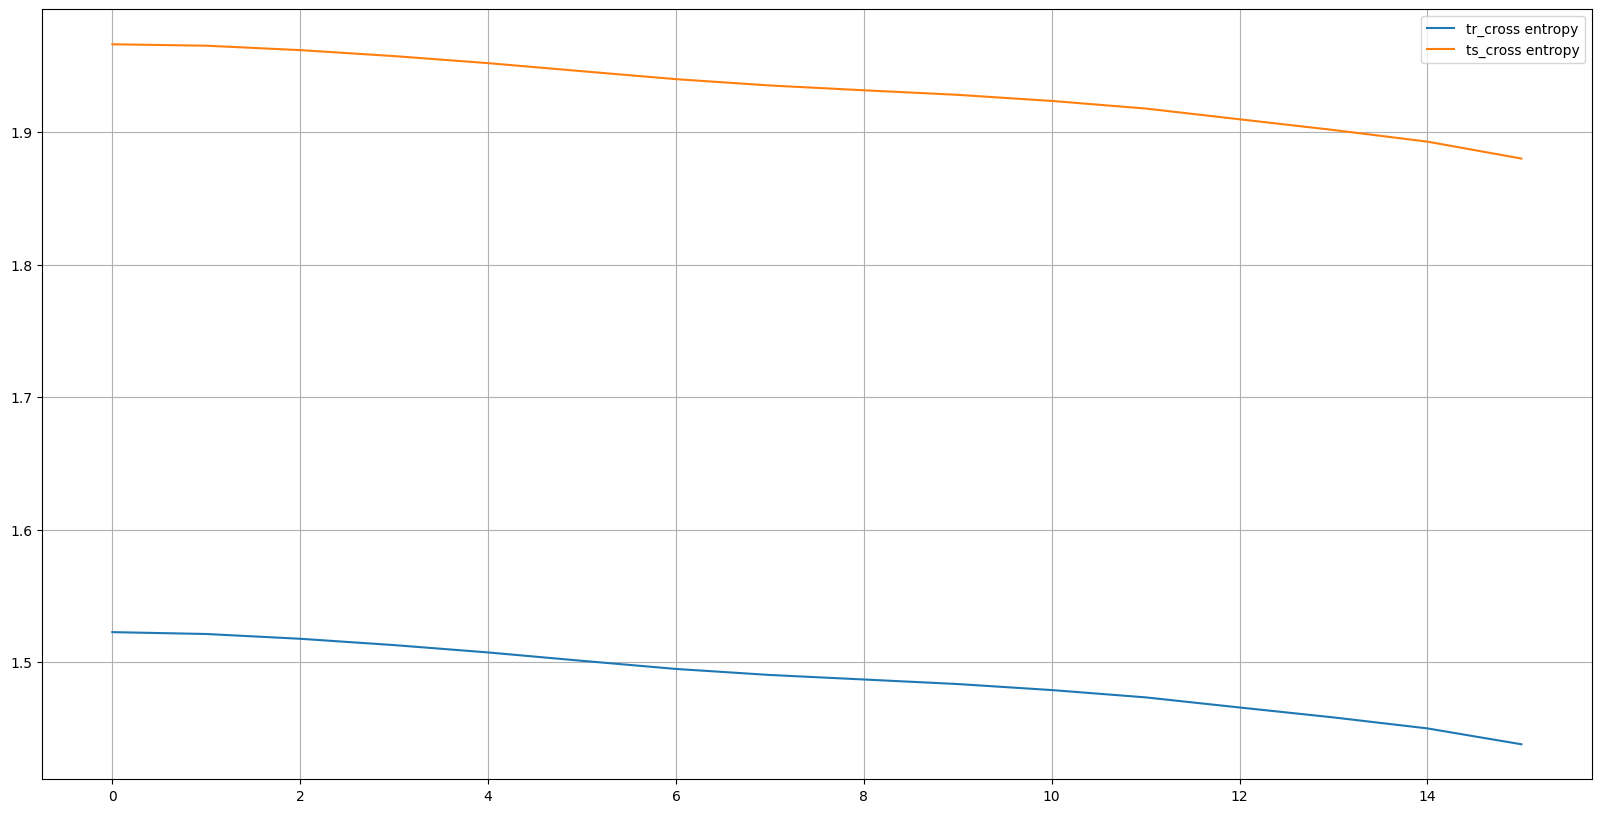

In [11]:
_base_plot(tr_loss, ts_loss, name='cross entropy')

Plot of training and test Accuracy.

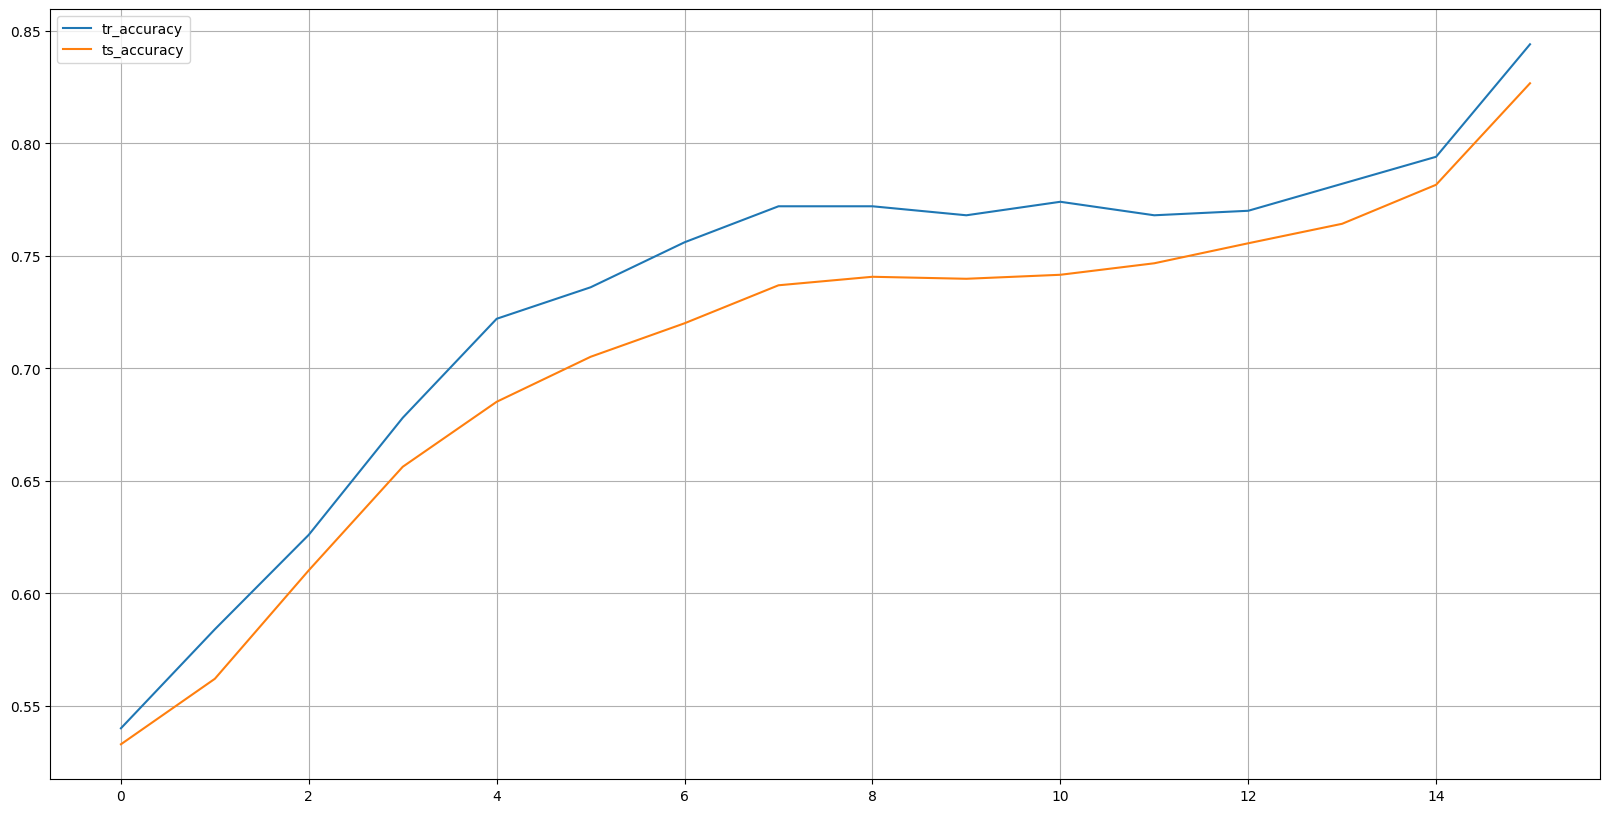

In [12]:
_base_plot(tr_metric, ts_metric, name='accuracy')